In [1]:
#Load the data using pandas
#Import all the required packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import inv

#Reading the file into pandas
Bank = pd.read_csv('bank.csv',header = 0,delimiter = ';')
print(Bank.shape)

#print("Numerical variables\n\n",Bank.describe())
#print("\nCategorical variables\n\n",Bank.describe(include = ['O']))
#print(Bank['y'].unique())

#Converting discrete values to categorical variable datatype
col = ['job','marital','education','default','housing','loan','contact','month','poutcome','y']
for each in col:
    Bank[each] = Bank[each].astype('category') 
#print(Bank.head())

(4521, 17)


In [2]:
Bank = Bank.drop('month', 1)
Bank = Bank.drop('day', 1)
Bank = Bank.drop('duration', 1)

In [3]:
#1.Converting non-numeric values to numric values; Hot-one encoding
Bank = pd.get_dummies(Bank,drop_first = True)
print(Bank.head())

   age  balance  campaign  pdays  previous  job_blue-collar  job_entrepreneur  \
0   30     1787         1     -1         0                0                 0   
1   33     4789         1    339         4                0                 0   
2   35     1350         1    330         1                0                 0   
3   30     1476         4     -1         0                0                 0   
4   59        0         1     -1         0                1                 0   

   job_housemaid  job_management  job_retired  ...    education_unknown  \
0              0               0            0  ...                    0   
1              0               0            0  ...                    0   
2              0               1            0  ...                    0   
3              0               1            0  ...                    0   
4              0               0            0  ...                    0   

   default_yes  housing_yes  loan_yes  contact_telephone  cont

In [4]:
#2.hecking for na values in any rows
print("NA's present : ",Bank.isnull().any().any())

NA's present :  False


In [5]:
#3. Split the data into test and train
#Generate a random list of true and false and assign train and test based on those values
split = np.random.rand(len(Bank)) < 0.8
#Assign train to true
train = Bank[split]
#Assign test to false
test = Bank[~split]

In [6]:
#Seperating x and y data
xTrain = train.loc[:,train.columns != 'y_yes']
yTrain = train.loc[:,train.columns == 'y_yes']
xTest = test.loc[:,test.columns != 'y_yes']
yTest = test.loc[:,test.columns == 'y_yes']

#Normalizing the data
numerical = ['age','campaign','pdays','previous']
for each in numerical:
    xTrain[each] = (xTrain[each] - xTrain[each].min())/(xTrain[each].max()-xTrain[each].min())
for each in xTest.columns.values:
    xTest[each] = (xTest[each] - xTest[each].min())/(xTest[each].max()-xTest[each].min())
    
    
#Adding bias to x data
xTest = np.column_stack([xTest,np.ones(len(xTest))]) 


/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [7]:
#Adding y data to train dataset, to avoid mismatch during shuffling
train = xTrain.copy()
train['y_yes'] = yTrain
#print(train.columns.values)

In [8]:
#Shuffling the data each time mini-batch is called and splitting into respective train ans test data
def shuffleAndSplit(trainS,splits):
    trainS.sample(frac=1)
    batch = np.array_split(trainS, splits)
    return(batch)

In [9]:
#Log - likelihood function
def logLikelihood(x, y, beta,lamda):
    scores = x.dot(beta)
    logLoss = np.sum(y*scores - np.log(1 + np.exp(scores)))
    reg = float(2*lamda*beta.T.dot(beta))
    return (-logLoss+reg)

In [10]:
#Splitting data to trian and test
def trainSplit(trainSp):
    x = trainSp.loc[:,trainSp.columns != 'y_yes']
    x = np.column_stack([x,np.ones(len(x))])
    y = trainSp.loc[:,trainSp.columns == 'y_yes']
    return(x,y)

In [11]:
#To compute the sigmoid of x, beta
def sigmoid(X):
    dnr = 1.0 + np.e ** (-1.0 * X)
    return(1.0/dnr)

In [12]:
#Hessian
def hessian(x,y,beta,lamda):
    W = np.zeros((x.shape[0], x.shape[0]), float)
    p = sigmoid(x.dot(beta))
    p1 = p*(1-p)
    np.fill_diagonal(W, p1)
    temp = np.matmul(W,x)
    grad = np.matmul(x.T,temp)
    I = np.identity(beta.shape[0])
    reg = -2*lamda*I
    return(grad+reg)

In [13]:
#Gradient
def gradient(x,y,beta):
    sig = y - sigmoid(np.matmul(x,beta))
    return(np.matmul(x.T,sig))

In [14]:
#RMSE
def lossRMSE(x,y,beta):
    yPredicted = np.array(x.dot(beta))
    leastSquareLoss = (np.square(y-yPredicted)).sum()
    return(leastSquareLoss)

In [34]:
#Mini batch Gradient Descent
def mini_BGD(trainGd,xTest,yTest,alpha,lamda,batchsize,epoch):
    beta = np.zeros((trainGd.shape[1],1))
    rmse,ii,rmseTest,llossTest,llossTrain = [],[],[],[],[]
    #Loop for epochs
    for each in range(epoch):
        minibatch = shuffleAndSplit(trainGd,int(trainGd.shape[0]/batchsize))
        #Loop for minibatch
        for every in minibatch:
            x,y = trainSplit(every)
            lossOld = logLikelihood(x,y,beta,lamda)
            betaNew = beta + alpha*np.matmul(inv(hessian(x,y,beta,lamda)),gradient(x,y,beta))
            lossNew = logLikelihood(x,y,betaNew,lamda)
             #alpha = boldDriver(alpha,lossOld,lossNew)
            if float(lossOld-lossNew) < 0.00000000000000000000001:
                print("Optimal beta found : \n",betaNew)
                break
            if each == epoch :
                print("Did not converge")
            beta = betaNew
        ii.append(each)
        llossTrain.append(y.T.dot(np.log(sigmoid(x.dot(beta)))) - (1-y).T.dot(np.log(1-sigmoid(x.dot(beta)))))
        rmse.append(np.sqrt(lossRMSE(x,y,beta)/xTrain.shape[0]))
        temp = lossRMSE(xTest,yTest,beta)
        llossTest.append(yTest.T.dot(np.log(sigmoid(xTest.dot(beta)))) - (1-yTest).T.dot(np.log(1-sigmoid(xTest.dot(beta)))))
        rmseTest.append(np.sqrt(temp/xTest.shape[0]))
    return (ii,rmse,rmseTest,llossTrain,llossTest)


In [16]:
#Plot RMSE
def plot1(i,rmse,rmseTest):
    f, axes = plt.subplots(1,2)
    axes[0].plot(i, rmse,'blue')
    axes[0].set_ylabel('Train RMSE')
    axes[0].set_xlabel('Epoch')
    axes[0].set_title('Epoch vs Train RMSE')
    axes[1].plot(i, rmseTest,'green')
    axes[1].set_ylabel('Test RMSE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_title('Epoch vs Test RMSE')
    plt.show()

In [17]:
#Plot log loss
def plot2(i,lloss,llossTest):
    f, axes = plt.subplots(1,2)
    axes[0].plot(i, lloss,'blue')
    axes[0].set_ylabel('Train log loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_title('Epoch vs Train log loss')
    axes[1].plot(i, llossTest,'green')
    axes[1].set_ylabel('Test log loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_title('Epoch vs log loss')
    plt.show()

Optimal beta found : 
 [[  2.75630116e-01]
 [ -2.20847932e-06]
 [ -4.30355112e-01]
 [ -4.50663169e-01]
 [  3.23825497e-02]
 [  5.18490858e-02]
 [  1.51651410e-02]
 [ -1.07047220e-02]
 [  2.20548224e-02]
 [  1.84951448e-01]
 [ -3.06473568e-02]
 [  5.95676921e-02]
 [  8.08985058e-02]
 [  1.24103116e-02]
 [ -3.02893564e-02]
 [  3.84912301e-03]
 [ -3.15193711e-02]
 [ -5.95094642e-03]
 [  5.18668293e-02]
 [  6.72982739e-02]
 [ -4.44153596e-02]
 [ -1.76906291e-02]
 [ -1.83440426e-02]
 [  7.77163266e-03]
 [  5.56124817e-02]
 [ -4.64308027e-02]
 [  5.67090016e-02]
 [  8.48747620e-01]
 [  2.60103280e-02]
 [ -4.71270837e-01]]
Optimal beta found : 
 [[  3.23122777e-01]
 [ -7.48912299e-06]
 [ -6.42339775e-01]
 [  3.49558054e-01]
 [  2.56616428e+00]
 [  3.09552342e-02]
 [  4.52928503e-02]
 [ -8.53890980e-02]
 [  5.28276181e-02]
 [  4.13082796e-01]
 [ -1.14971245e-01]
 [  2.24986041e-02]
 [  6.48377323e-02]
 [ -4.41154987e-02]
 [ -7.31914977e-02]
 [ -2.56573567e-02]
 [ -1.06492148e-01]
 [ -7.0506528

Optimal beta found : 
 [[  1.38169787e+00]
 [ -5.51143686e-05]
 [  2.79151790e-01]
 [  2.76544353e+00]
 [  2.64905367e+01]
 [  5.73650579e-02]
 [  7.76361324e-01]
 [ -5.05209471e-01]
 [  7.24071627e-01]
 [  4.20143282e-01]
 [  5.37819005e-02]
 [  6.83533372e-01]
 [  9.09532064e-01]
 [  2.31493454e-01]
 [  3.67601146e-01]
 [  4.43352073e-02]
 [ -4.61031732e-01]
 [  5.70501936e-01]
 [ -5.61501108e-01]
 [ -3.93185857e-01]
 [ -3.20595013e+00]
 [  1.11631777e-01]
 [  7.73488791e-02]
 [ -1.90267136e-01]
 [  7.59799803e-02]
 [ -1.51460520e-01]
 [ -1.13103959e+00]
 [  4.25538546e+00]
 [  3.88584997e+00]
 [ -5.53884766e+00]]
Optimal beta found : 
 [[  1.37750548e+00]
 [ -5.50912957e-05]
 [  2.23946347e-01]
 [  2.73058340e+00]
 [  2.65267269e+01]
 [  6.10791204e-02]
 [  7.78388126e-01]
 [ -5.04374934e-01]
 [  7.26950277e-01]
 [  4.22019333e-01]
 [  4.78972630e-02]
 [  6.84359264e-01]
 [  9.11493198e-01]
 [  2.33983176e-01]
 [  3.67587531e-01]
 [  4.43352073e-02]
 [ -4.63185912e-01]
 [  5.6861037

Optimal beta found : 
 [[  1.30090277e+00]
 [ -5.40044239e-05]
 [ -8.84445654e-01]
 [  2.22171651e+00]
 [  2.70680885e+01]
 [  1.26483742e-01]
 [  8.13946189e-01]
 [ -4.89832211e-01]
 [  7.75090397e-01]
 [  4.53711488e-01]
 [ -4.27944166e-02]
 [  6.96142705e-01]
 [  9.37266483e-01]
 [  2.77697711e-01]
 [  3.67331519e-01]
 [  4.43352073e-02]
 [ -5.00974809e-01]
 [  5.39305882e-01]
 [ -5.86180154e-01]
 [ -4.16359983e-01]
 [ -3.35062291e+00]
 [  1.08026052e-01]
 [  8.53961142e-02]
 [ -1.82305117e-01]
 [  4.36198943e-02]
 [ -2.17228552e-01]
 [ -5.17050843e-01]
 [  4.68090075e+00]
 [  3.81904423e+00]
 [ -5.38796604e+00]]
Optimal beta found : 
 [[  1.29615009e+00]
 [ -5.39044848e-05]
 [ -9.57947460e-01]
 [  2.19623103e+00]
 [  2.70961010e+01]
 [  1.30436598e-01]
 [  8.16097627e-01]
 [ -4.88946809e-01]
 [  7.77881191e-01]
 [  4.55562229e-01]
 [ -4.76807867e-02]
 [  6.96716240e-01]
 [  9.38405321e-01]
 [  2.80331725e-01]
 [  3.67315609e-01]
 [  4.43352073e-02]
 [ -5.03258461e-01]
 [  5.3773166

Optimal beta found : 
 [[  1.20759132e+00]
 [ -5.15760314e-05]
 [ -2.39484188e+00]
 [  1.80700741e+00]
 [  2.75425455e+01]
 [  2.02861884e-01]
 [  8.55794837e-01]
 [ -4.72264198e-01]
 [  8.27510298e-01]
 [  4.88524886e-01]
 [ -1.29524203e-01]
 [  7.05249263e-01]
 [  9.53609347e-01]
 [  3.28466154e-01]
 [  3.67027202e-01]
 [  4.43352073e-02]
 [ -5.45314722e-01]
 [  5.11623855e-01]
 [ -6.12457793e-01]
 [ -4.33482526e-01]
 [ -3.49174676e+00]
 [  1.04673518e-01]
 [  9.35923288e-02]
 [ -1.74529621e-01]
 [  1.30369815e-02]
 [ -2.87780063e-01]
 [ -8.89439771e-02]
 [  5.06553876e+00]
 [  3.79130188e+00]
 [ -5.26622630e+00]]
Optimal beta found : 
 [[  1.20254222e+00]
 [ -5.14213031e-05]
 [ -2.47997725e+00]
 [  1.78885069e+00]
 [  2.75645033e+01]
 [  2.06939350e-01]
 [  8.58050059e-01]
 [ -4.71292594e-01]
 [  8.30238187e-01]
 [  4.90333836e-01]
 [ -1.33785615e-01]
 [  7.05637896e-01]
 [  9.54205839e-01]
 [  3.31170383e-01]
 [  3.67011382e-01]
 [  4.43352073e-02]
 [ -5.47699252e-01]
 [  5.1028041

Optimal beta found : 
 [[  1.11548944e+00]
 [ -4.84795880e-05]
 [ -3.98943525e+00]
 [  1.52638938e+00]
 [  2.79002319e+01]
 [  2.76743782e-01]
 [  8.97095825e-01]
 [ -4.53982980e-01]
 [  8.76241561e-01]
 [  5.20662644e-01]
 [ -2.02874113e-01]
 [  7.11230870e-01]
 [  9.61448404e-01]
 [  3.77414914e-01]
 [  3.66752681e-01]
 [  4.43352073e-02]
 [ -5.88900293e-01]
 [  4.88745789e-01]
 [ -6.37612939e-01]
 [ -4.45408622e-01]
 [ -3.61976927e+00]
 [  1.01814438e-01]
 [  1.01287335e-01]
 [ -1.68018271e-01]
 [ -1.31904441e-02]
 [ -3.54792920e-01]
 [  2.17516633e-01]
 [  5.39692070e+00]
 [  3.79381024e+00]
 [ -5.17732217e+00]]
Optimal beta found : 
 [[  1.11031799e+00]
 [ -4.82906842e-05]
 [ -4.08130864e+00]
 [  1.51342036e+00]
 [  2.79179677e+01]
 [  2.80869596e-01]
 [  8.99431907e-01]
 [ -4.52916546e-01]
 [  8.78928303e-01]
 [  5.22420413e-01]
 [ -2.06771641e-01]
 [  7.11509950e-01]
 [  9.61732137e-01]
 [  3.80146513e-01]
 [  3.66738226e-01]
 [  4.43352073e-02]
 [ -5.91360157e-01]
 [  4.8754469

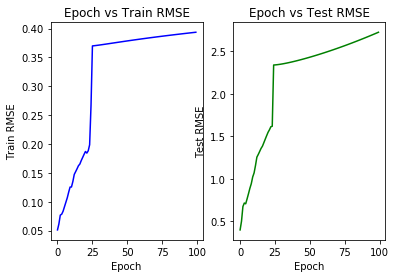

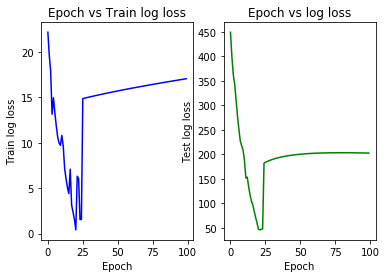

In [44]:
#Calling function
ii_3,rmse_3,rmseTest_3,llossTrain_3,llossTest_3 = mini_BGD(train,xTest,yTest,0.001,0.001,50,100)
plot1(ii_3,rmse_3,rmseTest_3)
plot2(ii_3,llossTrain_3,llossTest_3)